In [17]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import GPy
import scipy.integrate as integrate


In [18]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(1.0)).pdf(s)

In [108]:
def sample_function(x_range, N=100, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = gpy.kern.src.rbf.RBF(input_dim=dx,lengthscale=1.0)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
    mu = np.zeros(x.shape[0])
#     y = np.atleast_2d(normal(x[:,1])).T
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.0

    def f(x): return m.predict(x)[0]
    return f,m,x
x_range = np.array([[-3.0,-3.0], [3.0,3.0]])
f,m,x = sample_function(x_range)
# m.plot()

(5, 2)
[[-2.10752687e-04]
 [ 1.34224066e+00]
 [ 3.27564452e-02]
 [ 4.16085692e-01]
 [-2.86366142e-02]]


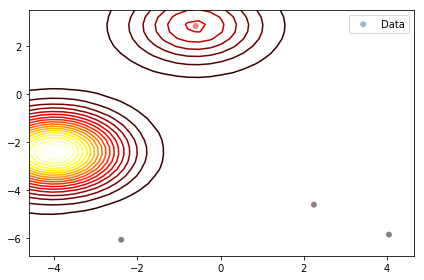

In [111]:
# k = GPy.kern.src.rbf.RBF(input_dim=1,lengthscale=0.1)
# kernel = RBF(1.0, (1e-2, 1e2))
x = np.random.normal(0,4,(5,2))
print x.shape
y = f(x)
gp = GPy.models.GPRegression(x, y, GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
gp.plot()
print y

In [113]:
x = np.array([[0.3,0.3]])
u,v = gp.predict(x)
print u, v

def get_mean_func(gp):
    def f(x):
        Kxpx = gp.kern.K(x,gp.X)
        return np.dot(Kxpx,gp.posterior.woodbury_vector)
    return f

def get_cov_func(gp):
    def f(x,y):
        Kxy = gp.kern.K(x,y)
        K1 = gp.kern.K(x,gp.X)
        K2 = gp.kern.K(gp.X,y)
        return Kxy - K1.dot(gp.posterior.woodbury_inv.dot(K2))
    return lambda x,y: f(x,y)

# cov1 = lambda x,y: gp.kern.K(np.array([[x]]),np.array([[y]]))
# cov2 = (lambda x,y: gp.kern.K(np.array([[x]]),gp.X).dot(gp.posterior.woodbury_inv.dot(gp.kern.K(gp.X,np.array([[y]])))))
x = np.array([[0.3,0.3,0.3]])
print get_mean_func(gp)(x)
print get_cov_func(gp)(x,x)

[[0.01124783]] [[0.99926966]]
[[0.01124783]]
[[0.99926966]]


In [68]:
b = np.array([0.0])
B = np.array([[1.0]])
def bintegrate(gp,b,B):
    n,dim = gp.X.shape
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = determ * expon
    mean = np.dot(z.T,gp.posterior.woodbury_vector)
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, gp.posterior.woodbury_inv.dot(z))
    return mean[0][0], var[0][0]
bintegrate(m,b,B)

ValueError: shapes (2,2) and (1,1) not aligned: 2 (dim 1) != 1 (dim 0)

In [75]:
# b = np.array([0.0])
# B = np.array([[1.0]])
def integrate_dim(gp, sdim,a,b, B):
    n,_ = gp.X.shape
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)    
    X = gp.X
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :sdim]
        xa = X[i, sdim:]
        factor = np.exp(-0.5 * np.sum((xa-a)**2 / (length_scale ** 2)))
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = factor*determ * expon
    mean = np.dot(z.T,gp.posterior.woodbury_vector)
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, gp.posterior.woodbury_inv.dot(z))
    return mean[0][0], var[0][0], z
mu,var,z =  integrate_dim(gp,1,np.array([0.0]),b,B)
# print mu,var,z


def bq_acquisition(gp,sdim,a,b,B,xs,z):
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)    
    X = gp.X
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    variances = np.zeros((xs.shape[0]))
    for i in range(xs.shape[0]):
        x = xs[i, :]
        xa = np.concatenate((xs[i, :],a))
        Xnew = np.vstack((gp.X, xa))
        K = gp.kern.K(Xnew)
        K[np.diag_indices_from(K)] += 1e-10
        ztemp = determ * np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        ztemp = np.vstack((z, ztemp))
        L = cholesky(K, lower=True)
        Kz = cho_solve((L, True), ztemp)
        variances[i] = var_determ - np.dot(ztemp.T, Kz)
    sorted_vars = variances.argsort()
    return xs[sorted_vars[:1]]
# print bq_acquisition(gp,1,np.array([0.0]),b,B,np.array([[-1.0],[1.0],[2.0],[3.5]]),z)

ValueError: shapes (1,1) and (2,2) not aligned: 1 (dim 1) != 2 (dim 0)

In [118]:
b = np.array([0.0])
B = np.array([[1.0]])
# b = np.array([0.0,0.0])
# B = np.array([[1.0,0.0],[0.0,1.0]])
gps = []
def OPT(f,gp,b,B,sdim,adim):
    for i in range(100):
        print "iter %d" % i
        actions = np.random.uniform(-10,10, (500, adim))
        UCB = lambda a: integrate_dim(gp, sdim, a, b,B)[0] + 3* np.sqrt(integrate_dim(gp, sdim, a, b,B)[1])
#         Vars = lambda a: 50000000.0 * integrate_dim(gp, sdim, a, prior[0], prior[1])[1]
#         Mus = lambda a: integrate_dim(gp, sdim, a, prior[0], prior[1])[0]
#         D[i] =  (actions, np.apply_along_axis(Mus, 1, actions),np.apply_along_axis(Vars, 1, actions),np.apply_along_axis(UCB, 1, actions))
        maxa = max(actions, key=UCB)
        print maxa
        _,_,z = integrate_dim(gp, sdim, maxa,b,B)
        xs = np.random.uniform(-10.0,10.0, (500, sdim))
        chosen = bq_acquisition(gp, sdim, maxa, b,B, xs,z)
        X = gp.X
        Y = gp.Y
        chosen_columns = np.repeat(np.reshape(maxa,(1,-1)),chosen.shape[0],axis=0)
        newX = np.hstack((chosen, chosen_columns))
        Xnew = np.vstack((X, newX))
        Yadd = newX.copy()
        Yadd = f(Yadd)
        Ynew = np.vstack((Y, Yadd))
        gp = GPy.models.GPRegression(Xnew, Ynew, GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
        gps.append(gp)
#         gp.plot()
    return gp
newgp = OPT(f,gp,b,B,1,1)
        

iter 0
[0.92009148]
iter 1
[-0.10134401]
iter 2
[1.68012183]
iter 3
[1.52942697]
iter 4
[-1.67764579]
iter 5
[9.97240463]
iter 6
[-9.97776282]
iter 7
[6.90173676]
iter 8
[-7.62727783]
iter 9
[-3.69022996]
iter 10
[1.77151211]
iter 11
[5.08807558]
iter 12
[-5.97556238]
iter 13
[8.51476841]
iter 14
[2.20473176]
iter 15
[-0.79930087]
iter 16
[1.95045707]
iter 17
[2.01660004]
iter 18
[-8.7958616]
iter 19
[1.74687665]
iter 20
[1.78643708]
iter 21
[1.78977303]
iter 22
[1.90552034]
iter 23
[1.88144784]
iter 24
[1.8300469]
iter 25
[1.9020054]
iter 26
[-0.4270041]
iter 27
[-0.47514938]
iter 28
[1.84189507]
iter 29
[1.88207907]
iter 30
[1.81685173]
iter 31
[1.88896598]
iter 32
[1.85544962]
iter 33
[1.83515927]
iter 34
[1.84303375]
iter 35
[1.84895739]
iter 36
[1.8423718]
iter 37
[4.17070567]
iter 38
[1.8498241]
iter 39
[1.89521762]
iter 40
[1.84063115]
iter 41
[1.8936404]
iter 42
[1.89290801]
iter 43
[1.84882124]
iter 44
[1.83977192]
iter 45
[1.8263113]
iter 46
[1.86098472]
iter 47
[1.88392909]


 /Library/Python/2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:invalid value encountered in sqrt


[1.86251729]
iter 55
[1.83463949]
iter 56
[1.82014575]
iter 57
[1.82460101]
iter 58
[1.87790906]
iter 59
[1.83337501]
iter 60
[1.86301592]
iter 61
[1.85092019]
iter 62
[1.83389956]
iter 63
[1.83592455]
iter 64
[1.78364369]
iter 65
[1.86382269]
iter 66
[1.81834927]
iter 67
[1.82437776]
iter 68
[1.78293142]
iter 69
[1.95295962]
iter 70
[1.86871502]
iter 71
[1.79441176]
iter 72
[1.85976581]
iter 73
[1.87317158]
iter 74
[1.84866506]
iter 75
[1.89152565]
iter 76
[1.94716434]
iter 77
[1.74751023]
iter 78
[1.99015149]
iter 79
[1.75836207]
iter 80
[1.97132964]
iter 81
[1.89154413]
iter 82
[1.86751957]
iter 83
[1.8151677]
iter 84


KeyboardInterrupt: 

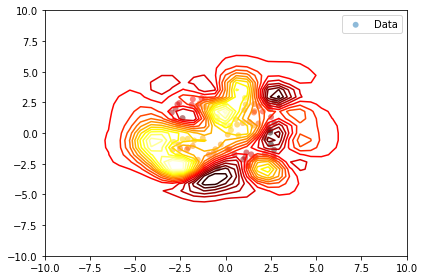

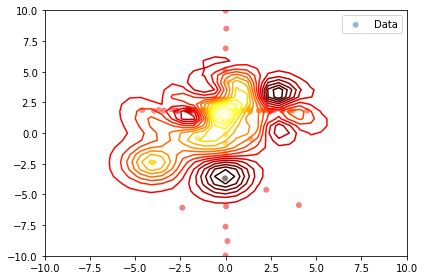

In [119]:
m.plot((-10,10))
gps[-1].plot((-10,10))

REFERENCE


 /Library/Python/2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:invalid value encountered in sqrt
 /Library/Python/2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:invalid value encountered in sqrt


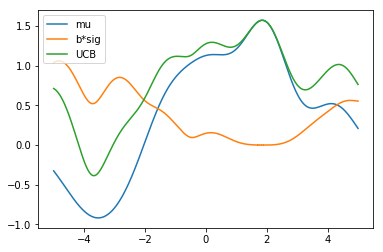

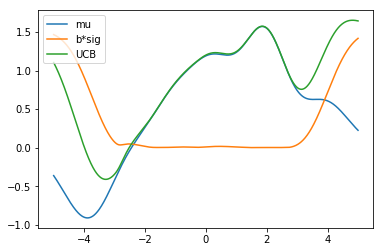

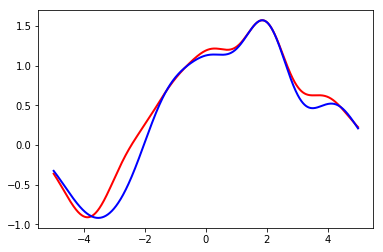

In [120]:
print "REFERENCE"
actions = np.linspace(-5.0,5.0,1000)
def plot_reference(m,actions):
    mus = []
    var = []
    tot = []
    for a in actions:
        out = integrate_dim(m,1, a, b,B)
        mus.append(out[0])
        var.append(2*np.sqrt(out[1]))
        tot.append(out[0] + 2*np.sqrt(out[1]))
    plt.plot(actions, mus,label='mu')
    plt.plot(actions, var,label='b*sig')
    plt.plot(actions, tot,label='UCB')
    plt.legend(loc='upper left')
    plt.show()
plot_reference(gps[-1],actions)
plot_reference(m,actions)

def plot_error(m,gp):
    mus1 = []
    mus2 = []
    for a in actions:
        out1 = integrate_dim(m, 1, a, b,B)
        out2 = integrate_dim(gp, 1, a, b,B)
        mus1.append(out1[0])
        mus2.append(out2[0])
    plt.plot(actions, mus1, 'r', lw=2)
    plt.plot(actions, mus2, 'b', lw=2)
    plt.show()
plot_error(m,gps[-1])

In [103]:
gps[0].Y

ObsAr([[ 1.88049397e-01],
       [-5.22120052e-07],
       [-1.78138789e-01],
       [-8.85694104e-02],
       [-2.30166709e-02],
       [-7.39653046e-06],
       [ 8.56666655e-02],
       [-9.01564757e-04],
       [-1.31333266e-01],
       [-7.61186011e-04],
       [ 7.13802095e-02],
       [ 6.18645397e-01],
       [-1.17024483e+00],
       [-6.86636370e-11],
       [-8.64447680e-08],
       [ 1.51436217e-02],
       [-9.58702364e-03],
       [-4.56239335e-15],
       [-8.19764737e-02],
       [-7.82342886e-11],
       [-3.50296255e-23],
       [-4.13034312e-07],
       [ 2.74950486e-01],
       [ 9.36217689e-02],
       [ 7.71357966e-09],
       [ 5.81990521e-02],
       [-1.10828145e-14],
       [ 1.31253999e-01],
       [ 8.74797431e-01],
       [-4.88987908e-08],
       [-1.63832730e+00],
       [-4.74877684e-01],
       [-5.90965551e-01],
       [-2.21206834e-02],
       [-1.21914998e-16],
       [-2.63538148e-01],
       [-7.28616474e-08],
       [ 6.14473567e-01],
       [-4.7